In [3]:
# bipartite graph where anomalous nodes have entire row distributed 
# by H1 distribution and non-anomalous nodes have entire row distributd
# by uniform


import numpy as np
#import spectral_embedding as se
import matplotlib as mpl
import matplotlib.pyplot as plt

from itertools import product
from matplotlib import ticker, cm
from scipy.optimize import minimize

import scipy.stats
import random

In [4]:
def logit(x):
    return 1/(1 + np.exp(-x))
"""
def Renyi_Divergence(t, pi, b1, b2, b3, c1, c2, c3):   
    if (c1 == 0 and c2 == 0) or (c2 == 0 and c3 == 0):
        return 0.0
    else:
        return 0.5*t*(1-t)*(pi*(b1-b2)**2/((1-t)*c1 + t*c2) + (1-pi)*(b2-b3)**2/((1-t)*c2 + t*c3))
    
def fThres(x, params):
    t = logit(x)
    pi, b1, b2, b3, c1, c2, c3 = params
    return -Renyi_Divergence(t, pi, b1, b2, b3, c1, c2, c3)
"""

'\ndef Renyi_Divergence(t, pi, b1, b2, b3, c1, c2, c3):   \n    if (c1 == 0 and c2 == 0) or (c2 == 0 and c3 == 0):\n        return 0.0\n    else:\n        return 0.5*t*(1-t)*(pi*(b1-b2)**2/((1-t)*c1 + t*c2) + (1-pi)*(b2-b3)**2/((1-t)*c2 + t*c3))\n    \ndef fThres(x, params):\n    t = logit(x)\n    pi, b1, b2, b3, c1, c2, c3 = params\n    return -Renyi_Divergence(t, pi, b1, b2, b3, c1, c2, c3)\n'

In [6]:
def standard_basis(K, i):
    r = np.zeros(K)
    r[i] = 1
    return r

def S_matrix(C, k, l, t):
    return (1 - t) * np.diag(C[k]) + t * np.diag(C[l])

def R_div(t, PI, B, C, k, l):
    K = len(PI)
    try: center = B @ PI @ np.linalg.inv(S_matrix(C, k, l, t)) @ B
    except np.linalg.LinAlgError: return 0.0
    vect = standard_basis(K, k) - standard_basis(K, l)
    return t * (1 - t)/2 * vect.T @ center @ vect

def fThres(x, params):
    t = logit(x)
    PI, B, C, k, l = params
    return -R_div(t, PI, B, C, k, l)

100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


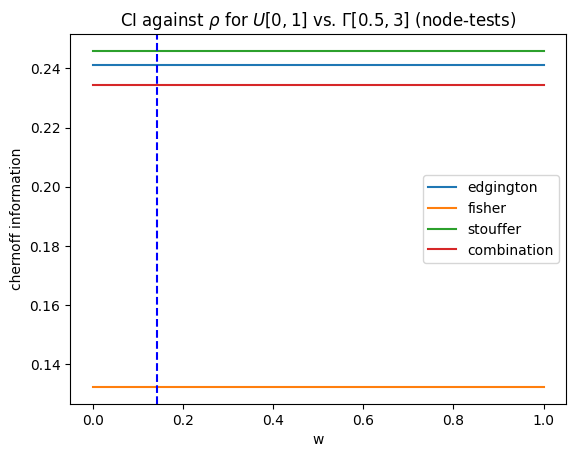

 33%|███▎      | 1/3 [00:05<00:10,  5.34s/it]


KeyboardInterrupt: 

In [62]:
def R_div_arb(t, PI, P, Q):
    return - np.log(((P ** t) * (Q ** (1 - t))).sum())

def fThres_arb(x, params):
    t = logit(x)
    PI, P, Q = params
    return -R_div_arb(t, PI, P, Q)

def arbitrary_CI(PI, X, Y, n_buckets = 10):
    P, Q = np.zeros(n_buckets), np.zeros(n_buckets)

    mi, ma = min(X.min(), Y.min()), max(X.max(), Y.max())
    delt = ma - mi
    #print(mi,ma,delt)
    for x in X: P[min(n_buckets - 1, int(((x - mi)/delt) * n_buckets))] += 1
    for y in Y: Q[min(n_buckets - 1, int(((y - mi)/delt) * n_buckets))] += 1
    P /= len(X); Q /= len(Y)

    #print (P, Q)
    #return -R_div_arb(0.5, PI, P, Q)
    res = minimize(fThres_arb, 0.0, [PI, P,Q], method='TNC', tol=1e-10)
    CI = -res.fun
    return CI

def truncated_sample(dist, params, rho = 0.5, N = 1000_000):
    R = dist.rvs(*params, size=2*N)

    R = R[R <= 1]
    R = R[R > 0]
    while len(R) < N:
        R = np.concatenate((R, dist.rvs(*params, size=N)))
        R = R[R <= 1]
        R = R[R > 0]
    R = R[:N]
    for k in range(N):
        if random.random() > rho: R[k] = 1#random.random() #R[k] = 1
    return R

ga, gb = 0.3,0.5


def pearson_transform(x):
    x = x / 1.1
    return np.log(1 - x)

def stouffer_transform(x):
    x = x / 1.01
    return scipy.stats.norm.ppf(x)
def test_all_transforms(d1, p1, d2, p2, rho,ga,gb):

    TRANSFORMS = [
        lambda x : x,
        lambda x : np.log(x),
        #lambda x : 0.25 + np.log(x) / 2,
        pearson_transform,
        stouffer_transform,
        lambda x : (1-ga) * np.log(x) + gb * x,
        
    ]

    return [
        arbitrary_CI(None, transform(X), transform(Y))
        for transform in TRANSFORMS
    ]


ga, gb = 2,2
for ga in [0.5,1,2]:
    for gb in [3,2,1,0.5]:


        gran = 2

        As = []
        Bs = []
        Cs = []
        Ds = []
        
        for rho in tqdm(range(0, gran + 1)):
            a,b,_,c,d = test_all_transforms(scipy.stats.uniform, [], scipy.stats.gamma, [ga,0,1/gb], 1, ga,gb)
            #print (a,b)
            As.append(a); Bs.append(b); Cs.append(c); Ds.append(d)

        plt.plot([x / gran for x in range(0,gran + 1)], As, label="edgington")
        plt.plot([x / gran for x in range(0,gran + 1)], Bs, label="fisher")
        plt.plot([x / gran for x in range(0,gran + 1)], Cs, label="stouffer")
        plt.plot([x / gran for x in range(0,gran + 1)], Ds, label="combination")
        plt.xlabel("rho")
        plt.ylabel("chernoff information")
        plt.legend()
        if 1 + gb - ga != 0:
                w = (1 - ga)/(1 + gb - ga)
                if w >= 0 and w <= 1: plt.axvline(x = w, color = 'b', linestyle='--')
                plt.xlabel("w")
        plt.title(f"CI against $\\rho$ for $U[0,1]$ vs. $\Gamma[{ga},{gb}]$ (node-tests)")
        plt.show()

In [6]:
w

0.5

In [7]:
As = []
Bs = []critical+ 1)):
    a,b,_,c = test_all_transforms(scipy.stats.uniform, [], scipy.stats.beta, [0.5,1], rho/gran)
    #print (a,b)
    As.append(a); Bs.append(b); Cs.append(c)

plt.plot([x / gran for x in range(1,gran + 1)], As, label="edgington")
plt.plot([x / gran for x in range(1,gran + 1)], Bs, label="fisher")
plt.plot([x / gran for x in range(1,gran + 1)], Cs, label="stouffer")
plt.xlabel("rho")
plt.ylabel("chernoff information")
plt.legend()
plt.title(f"CI against $\\rho$ for $U[0,1]$ vs. $Be[{0.5},{1}]$")
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]


TypeError: test_all_transforms() missing 1 required positional argument: 'w'

In [ ]:
print (scipy.stats.gamma.var(ga,0,1/gb), scipy.stats.uniform.var(0, 1))
print (scipy.stats.gamma.mean(ga,0,1/gb), scipy.stats.uniform.mean(0, 1))

0.010000000000000002 0.08333333333333333
0.1 0.5


In [ ]:
for _ in range(5):
    print (test_all_transforms(scipy.stats.uniform, [], scipy.stats.beta, [0.5, 1]))

[84, 87, 82, 87]
[83, 85, 81, 85]
[84, 86, 82, 87]
[84, 86, 82, 86]
[85, 87, 83, 88]


In [8]:
def scalar_chernoff_information(PI, B, C, k = 0, l = 1):
    #print ([pi, mu_AA, mu_AB, mu_BB, s_AA, s_AB, s_BB])
    res = minimize(fThres, 0.0, [PI, B, C, k, l], method='TNC', tol=1e-10)
    CI = -res.fun
    return CI

def chernoff_information(PI, B, C, k = 0, l = 1):
    K = len(PI)
    CI = np.zeros((K, K))
    for k in range(K):
        for l in range(K):
            if k != l:
                res = minimize(fThres, 0.0, [PI, B, C, k, l], method='TNC', tol=1e-10)
                CI[k,l] = -res.fun
    return CI


In [9]:
rho = 1
def find_CI_analytical(alpha, beta, pi):
    b1 = 1 / (alpha+1); bp1 = rho*b1 
    b2 = 1 / (beta+1); bp2 = rho*b2
    b3 = 1/2; bp3 = rho*b3
    c1 = alpha / ((alpha+2)*(alpha+1)**2); cp1 = rho*c1 + rho*(1-rho)*b1**2
    c2 = beta / ((beta+2)*(beta+1)**2); cp2 = rho*c2 + rho*(1-rho)*b2**2
    c3 = 1/12; cp3 = rho*c3 + rho*(1-rho)*b3**2

    B = np.array([[bp1,bp2],[bp2,bp3]])
    C = np.array([[cp1,cp2],[cp2,cp3]])
    PI = np.diag([pi, 1-pi])

    return scalar_chernoff_information(PI, B, C)

def find_CI_analytical_log(alpha, beta, pi):
    b1 = alpha; bp1 = rho*b1
    b2 = beta; bp2 = rho*b2
    b3 = 1; bp3 = rho*b3
    c1 = alpha**2; cp1 = rho*c1 + rho*(1-rho)*b1**2
    c2 = beta**2; cp2 = rho*c2 + rho*(1-rho)*b2**2
    c3 = 1; cp3 = rho*c3 + rho*(1-rho)*b3**2

    B = np.array([[bp1,bp2],[bp2,bp3]])
    C = np.array([[cp1,cp2],[cp2,cp3]])
    PI = np.diag([pi, 1-pi])

    return scalar_chernoff_information(PI, B, C)

def find_CI_empirical(PI, DISTS, PARAMS, transform = lambda x : x, rho = 1):
    # PI:     PMF on communities
    # DISTS:  symmetric KxK matrix of distributions for community i -> community j
    # PARAMS: symmetric KxK matrix of parameters for community i -> community j

    N = 100_000
    K = len(PI)

    R = [[DISTS[i][j].rvs(*PARAMS[i][j], size=2*N) for j in range(K)] for i in range(K)]

    for i in range(K):
        for j in range(K):
            R[i][j] = R[i][j][R[i][j] <= 1]
            R[i][j] = R[i][j][R[i][j] > 0]
            while len(R[i][j]) < N:
                R[i][j] = np.concatenate((R[i][j], DISTS[i][j].rvs(*PARAMS[i][j], size=N)))
                R[i][j] = R[i][j][R[i][j] <= 1]
                R[i][j] = R[i][j][R[i][j] > 0]
            R[i][j] = R[i][j][:N]
            for k in range(N):
                if random.random() > rho: R[i][j][k] = 1
            R[i][j] = transform(R[i][j])

    R = np.array(R)
    B = np.mean(R, axis = 2)
    C = np.var(R, axis = 2)
    PI = np.diag(PI)
    #print ("here!")
    #return arbitrary_CI(PI, R)
    return chernoff_information(PI, B, C)

alpha = 0.1
beta = 0.9
pi = 0.5

BETA_PARAMS = [
    [[scipy.stats.beta, scipy.stats.beta], [scipy.stats.beta, scipy.stats.uniform]],
    [[[alpha,1], [beta,1]], [[beta,1], []]]
]

print (find_CI_analytical(alpha,beta,pi),     find_CI_empirical([pi, 1 - pi],BETA_PARAMS[0], BETA_PARAMS[1]))
print (find_CI_analytical_log(alpha,beta,pi), find_CI_empirical([pi, 1 - pi],BETA_PARAMS[0], BETA_PARAMS[1],lambda x : np.log(x)))

0.15206797174083336 [[0.         0.15094787]
 [0.15094787 0.        ]]
0.1602721911853912 [[0.         0.15870587]
 [0.15870587 0.        ]]


In [10]:
def find_mv_empirical(PI, DISTS, PARAMS, transform = lambda x : x, rho = 1):
    # PI:     PMF on communities
    # DISTS:  symmetric KxK matrix of distributions for community i -> community j
    # PARAMS: symmetric KxK matrix of parameters for community i -> community j

    N = 100_000
    K = len(PI)

    R = [[DISTS[i][j].rvs(*PARAMS[i][j], size=2*N) for j in range(K)] for i in range(K)]

    for i in range(K):
        for j in range(K):
            R[i][j] = R[i][j][R[i][j] <= 1]
            R[i][j] = R[i][j][R[i][j] > 0]
            while len(R[i][j]) < N:
                R[i][j] = np.concatenate((R[i][j], DISTS[i][j].rvs(*PARAMS[i][j], size=N)))
                R[i][j] = R[i][j][R[i][j] <= 1]
                R[i][j] = R[i][j][R[i][j] > 0]
            R[i][j] = R[i][j][:N]
            for k in range(N):
                if random.random() > rho: R[i][j][k] = 1
            R[i][j] = transform(R[i][j])

    R = np.array(R)
    np.ap
    LHS = -np.mean(np.log(min(1e3,R))/R, axis = 2)
    return LHS
    B = np.mean(R, axis = 2)
    C = np.var(R, axis = 2)
    PI = np.diag(PI)
    #print ("here!")
    #return arbitrary_CI(PI, R)
    return chernoff_information(PI, B, C)

In [31]:
def pearson_transform(x):
    x = x / 1.1
    return np.log(1 - x)

def stouffer_transform(x):
    x = x / 2
    return scipy.stats.norm.ppf(x)

from tqdm import tqdm
def test_all_transforms(PI, DISTS, PARAMS, rho = 1, w = 1):
    TRANSFORMS = [
        lambda x : x,
        lambda x : np.log(x),
        lambda x : 0.25 + np.log(x) / 2,
        pearson_transform,
        stouffer_transform,
        lambda x : w * np.log(x) + (1 - w) * x,
    ]

    return [
        find_CI_empirical(PI, DISTS, PARAMS, transform, rho)[0][1]
        for transform in TRANSFORMS
    ]

def standard_dist_matrix(dist, p1, p2 = None):
    if p2 is None: p2 = p1
    return [
        [[dist, dist], [dist, scipy.stats.uniform]],
        [[p1, p2], [p2, []]]
    ]

def bipartite_dist_matrix(dist, p1, p2 = None):
    if p2 is None: p2 = p1
    # normal, anomalous, test
    return [
        [
            [scipy.stats.uniform, scipy.stats.uniform, scipy.stats.uniform],
            [scipy.stats.uniform, scipy.stats.uniform, dist],
            [scipy.stats.uniform, dist, scipy.stats.uniform],
        ],
        [
            [[0.1,0.1], [0.2,0.2], [0,1]],
            [[0.2,0.2], [0.1,0.1], p1],
            [[0.2,0.2], p1, [0.1,0.1]],
        ],
    ]
#standard_dist_matrix = bipartite_dist_matrix
alpha = 0.1
beta = 0.9
pi = 0.5

S_PI = [pi, (1 - pi)]
gamma_dists, gamma_params = standard_dist_matrix(scipy.stats.gamma, [ga,0,1/gb])

In [ ]:
beta_dists, beta_params = standard_dist_matrix(scipy.stats.beta, [0.5,1], [beta,1])

test_all_transforms(S_PI, beta_dists, beta_params)

[0.0023744347363107154,
 0.00754702111931483,
 0.007095770685080246,
 0.0009365318319275451,
 0.005531407796728782]

100%|██████████| 21/21 [00:05<00:00,  3.93it/s]


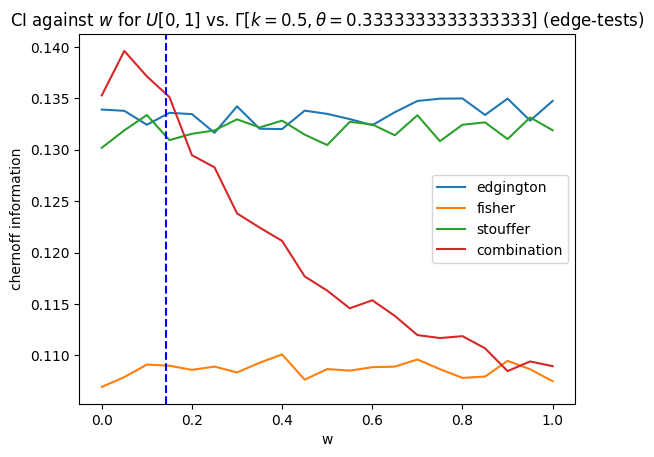

 10%|▉         | 2/21 [00:00<00:05,  3.45it/s]


KeyboardInterrupt: 

In [35]:
import matplotlib.pyplot as plt
from tqdm import tqdm
ga, gb = 2,2
for ga in [0.5,1,2]:
    for gb in [3,2,1,0.5]:
        gran = 20
        gamma_dists, gamma_params = standard_dist_matrix(scipy.stats.gamma, [ga,0,1/gb])
        #beta_dists, beta_params = standard_dist_matrix(scipy.stats.beta, [ga,gb])


        As = []
        Bs = []
        Cs = []
        Ds = []
        for rho in tqdm(range(gran + 1)):
            a,b,_,_,c,d = test_all_transforms(S_PI, gamma_dists, gamma_params, 1, rho / gran)
            #print (a,b)
            As.append(a); Bs.append(b); Cs.append(c); Ds.append(d)

        plt.plot([x / gran for x in range(gran + 1)], As, label="edgington")
        plt.plot([x / gran for x in range(gran + 1)], Bs, label="fisher")
        plt.plot([x / gran for x in range(gran + 1)], Cs, label="stouffer")
        plt.plot([x / gran for x in range(gran + 1)], Ds, label="combination")
        if 1 + gb - ga != 0:
            w = (1 - ga)/(1 + gb - ga)
            if w >= 0 and w <= 1: plt.axvline(x = w, color = 'b', linestyle='--')
        plt.xlabel("w")
        plt.ylabel("chernoff information")
        plt.legend()
        plt.title(f"CI against $w$ for $U[0,1]$ vs. $\Gamma[k = {ga},\\theta = {1/gb}]$ (edge-tests)")
        plt.show()

100%|██████████| 21/21 [00:05<00:00,  4.02it/s]


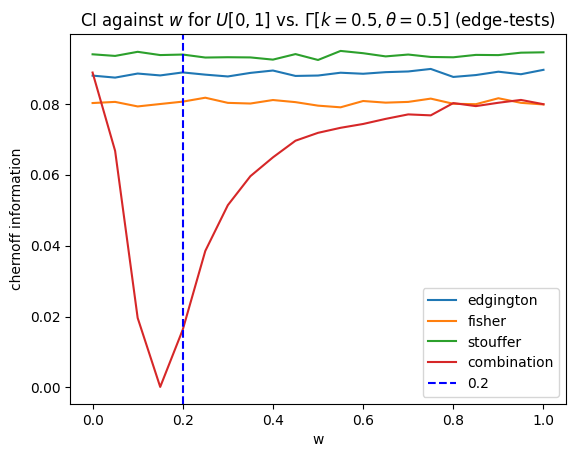

100%|██████████| 21/21 [00:05<00:00,  4.11it/s]


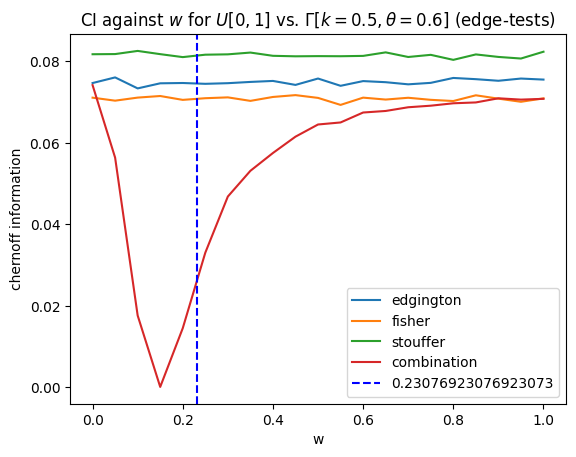

100%|██████████| 21/21 [00:05<00:00,  4.06it/s]


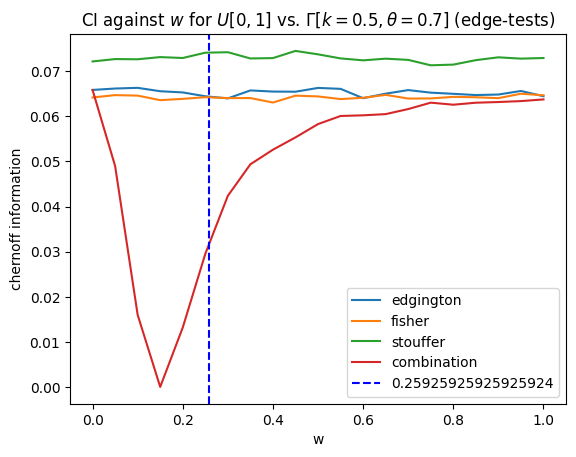

100%|██████████| 21/21 [00:05<00:00,  4.03it/s]


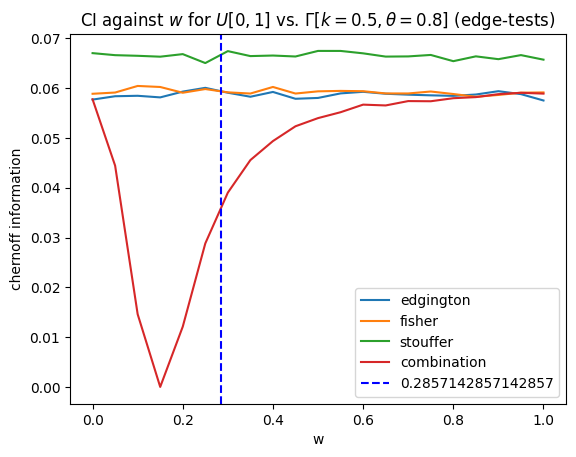

100%|██████████| 21/21 [00:05<00:00,  4.00it/s]


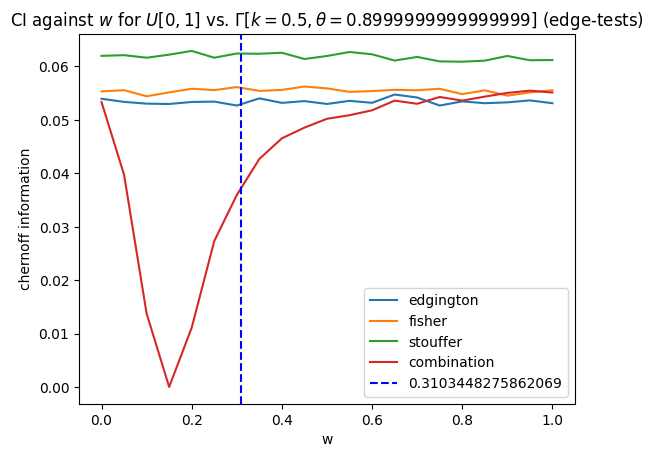

100%|██████████| 21/21 [00:05<00:00,  3.99it/s]


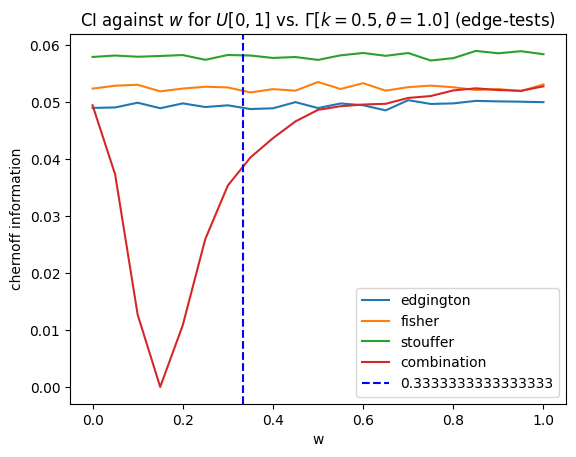

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
ga, gb = 2,2
for ga in [0.5]:
    for gb in [1/0.5,1/0.6,1/0.7,1/0.8,1/0.9,`1`]:
        gran = 20
        gamma_dists, gamma_params = standard_dist_matrix(scipy.stats.gamma, [ga,0,1/gb])

        As = []
        Bs = []
        Cs = []
        Ds = []
        for rho in tqdm(range(gran + 1)):
            a,b,_,_,c,d = test_all_transforms(S_PI, gamma_dists, gamma_params, 1, rho / gran)
            #print (a,b)
            As.append(a); Bs.append(b); Cs.append(c); Ds.append(d)

        plt.plot([x / gran for x in range(gran + 1)], As, label="edgington")
        plt.plot([x / gran for x in range(gran + 1)], Bs, label="fisher")
        plt.plot([x / gran for x in range(gran + 1)], Cs, label="stouffer")
        plt.plot([x / gran for x in range(gran + 1)], Ds, label="combination")
        if 1 + gb - ga != 0:
            w = (1 - ga)/(1 + gb - ga)
            if w >= 0 and w <= 1: plt.axvline(x = w, color = 'b', linestyle='--', label=f"{w}")
        plt.xlabel("w")
        plt.ylabel("chernoff information")
        plt.legend()
        plt.title(f"CI against $w$ for $U[0,1]$ vs. $\Gamma[k = {ga},\\theta = {1/gb}]$ (edge-tests)")
        plt.show()

In [ ]:
(1 - ga)/(1 + gb - ga)

0.14285714285714285

100%|██████████| 21/21 [00:06<00:00,  3.30it/s]


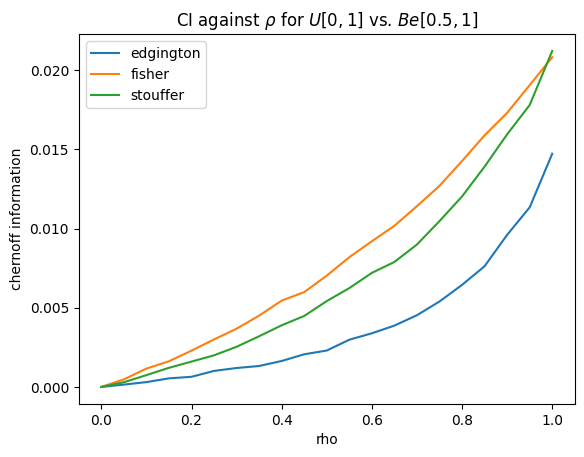

In [ ]:
ga, gb = 1,2
gran = 20
gamma_dists, gamma_params = standard_dist_matrix(scipy.stats.gamma, [ga,0,1/gb])

As = []
Bs = []
Cs = []
for rho in tqdm(range(gran + 1)):
    a,b,_,_,c = test_all_transforms(S_PI, beta_dists, beta_params, rho / gran)
    #print (a,b)
    As.append(a); Bs.append(b); Cs.append(c)

plt.plot([x / gran for x in range(gran + 1)], As, label="edgington")
plt.plot([x / gran for x in range(gran + 1)], Bs, label="fisher")
plt.plot([x / gran for x in range(gran + 1)], Cs, label="stouffer")
plt.xlabel("rho")
plt.ylabel("chernoff information")
plt.legend()
plt.title(f"CI against $\\rho$ for $U[0,1]$ vs. $Be[0.5,1]$")
plt.show()

In [ ]:
mu, s2 = 0.1, 0.25
norm_dists, norm_params = standard_dist_matrix(scipy.stats.norm, [mu, s2])

test_all_transforms(S_PI, norm_dists, norm_params)

[0.6934937219651887,
 0.7933079076116103,
 0.7952532682284921,
 0.6230388460368147,
 0.786392119682171]